# 공식 문서 튜토리얼
## 기초 챗봇 구성.

langgraph 기반의 기본적인 질문에 대한 응답이 가능한 구조의 챗봇 구성 방법. 

원본 공식 문서는 chatantropic 를 사용하지만, 이 문서에서는 chatopenai 를 사용함. 

In [ ]:
# # 필요한 패키지 설치
# # 주피터 노트북에 가상환경을 연동 위한 준비 
# pip install jupyter ipykernel
# # 주피터 노트북에 커널 추가하는 코드 python 가상환경을 주피터 노트북의 환경으로 사용할 경우 필수, 아나콘다 가상환경의 경우 필요 없을 수 있음. 
# python -m ipykernel install --user --name=graph_env(환경 명) --display-name "Python (langgraph)"(커널 명) 

# #langgraph 및 감시용 langsmith, llm 모델용 langchain_openai 설치. 
# !pip install -U langgraph langsmith langchain_openai
# # 검색용 tavily_python 및 langchain_community 설치
# pip install -U tavily-python langchain_community

In [1]:
import getpass
import os

#환경변수에 값 등록하기 위한 함수
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


In [2]:
# Tavily_api_key 입력 
_set_env("TAVILY_API_KEY")
#openai api key 저장.
_set_env("OPENAI_API_KEY")

## 기초적인 챗봇 구성

In [17]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):# state는 dict 구조로 생성. 
    # 메세지는 리스트 구성으로 생성, add_messages로 추가됨. 
    # annotated는 message가 어떻게 처리되는지를 정의. 이 코드에서는 리스트를 덮어쓰는게 아니라 갱신하는 구조로 작동.
    messages: Annotated[list, add_messages]

# State 기반으로 그래프 생성 및 변수에 할당. 
graph_builder = StateGraph(State)

llm  = ChatOpenAI(model="gpt-4o-mini")

# 챗봇 기능용 함수. state의 message를 llm에 입력.
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}



# 첫번째 요소는 고유한 노드의 이름, 두번째 요소는 호출할 함수 or 호출됬을때 사용할 객체
graph_builder.add_node("chatbot", chatbot)

# 첫번째 요소는 출발 노드, 두번재 요소는 도착 노드. 
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

# #노드 이름 변경 테스트용 코드 노드의 이름을 바꾸어 생성하고 연결하면 노드 이름이 변경되어 출력 됨. 
# graph_builder.add_node("ai_bot", chatbot)  # "chatbot" → "ai_bot"으로 변경
# graph_builder.add_edge(START, "ai_bot")  #  "chatbot" → "ai_bot"
# graph_builder.add_edge("ai_bot", END)    # "chatbot" → "ai_bot"
# graph = graph_builder.compile()

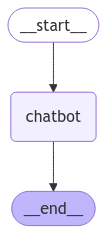

In [18]:
#그래프 구조 시각화 단계.
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

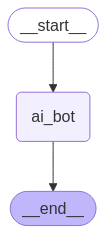

In [ ]:
# #그래프 구조 시각화 단계. 노드 명 바꾸었을때 시행된 결과임. 
# from IPython.display import Image, display

# try:
#     display(Image(graph.get_graph().draw_mermaid_png()))
# except Exception:
#     pass

In [ ]:
#그래프 업데이트 하기 위한 함수. 
def stream_graph_updates(user_input: str): #문자열로 입력
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):# 메세지를 초기화 하는 기능을 함. 
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        print("User: ", user_input)
        # 종료 하기 위한 함수. 
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  안녕
Assistant: 안녕하세요! 무엇을 도와드릴까요?
User:  너의 이름은 뭐니?
Assistant: 저는 AI 언어 모델이기 때문에 이름이 따로 없습니다. 그냥 "AI"나 "챗GPT"라고 불러주시면 됩니다. 어떻게 도와드릴까요?
User:  state의 내용을 전부 보여 줄 수 있니?
Assistant: 죄송하지만 특정 문서나 자료의 내용을 전부 보여드릴 수는 없습니다. 대신, 해당 주제에 대해 요약하거나 설명해드릴 수 있습니다. "state"라는 용어가 어떤 맥락에서 사용되는지 좀 더 구체적으로 말씀해 주시면 도움이 될 것 같습니다!
User:  너와 한 대화 기록을 보여 줘
Assistant: 죄송하지만, 이전 대화 기록을 보여드릴 수는 없습니다. 제가 사용자와의 개인적인 대화를 기록하지 않기 때문입니다. 그러나 어떤 질문이나 주제에 대해 자유롭게 이야기해 주시면, 최선을 다해 도와드리겠습니다!
User:  q
Goodbye!


In [ ]:
#주석 생략한 통합 버전. 
from typing import Annotated
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic #공식문서 원본 재현할 경우에만 사용. 
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm  = ChatOpenAI(model="gpt-4o-mini")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()